# Homework 8
# Change the 2-D Godunov's method to second-order accurate in time, using midpoint quantities Wm and Um (follow 1-D example)
# Then run the blast wave solution again and compare the results with the first-order in time results
# to demonstrate that second-order in time is more accurate. 

In [11]:
# 2-D Godunov scheme using midpoint of cell to make calculation (second order accurate) with midpoint cuts to plot progression. 

import numpy as np
import matplotlib.pylab as p
from mpl_toolkits.mplot3d import Axes3D 

L=100.; Nx=100; NGHOST=2; Ny=100
tend=10.1; Dtout=1.

Nxg=Nx+2*NGHOST  # Total grid number including ghost zones
Nyg=Ny+2*NGHOST

ist=2           # i direction: active zone starting grid number
ien=Nx+2        # i direction: active zone ending grid number
jst=2           # j direction: active zone starting grid number
jen=Ny+2

NHYDRO=5 # 5 varialbes, rho, mx1, mx2, mx3, E, or rho, vx1, vx2, vx3, pressure
gamma=1.4

dx=L/Nx
dy=L/Ny
dareax=dy       # area perpendicular to the x direction
dareay=dx       # area perpendicular to the y direction
dvol=dy*dx      # volume of each grid

Wsave=np.zeros((Nyg,Nxg,int(tend/Dtout)+1,NHYDRO), float)

def main():

    U=np.zeros((Nyg,Nxg,NHYDRO), float)  # conserved variable
    W=np.zeros((Nyg,Nxg,NHYDRO), float)  # primative variable
    Um=np.zeros((Nyg,Nxg,NHYDRO), float)  # conserved variable at mid point
    Wm=np.zeros((Nyg,Nxg,NHYDRO), float)  # primative variable at mid point
    Fluxx=np.zeros((Nyg,Nxg,NHYDRO), float)  # flux from the x-direction interface
    Fluxy=np.zeros((Nyg,Nxg,NHYDRO), float)  # flux from the y-direction interface
    fluxa=np.zeros(NHYDRO,float)             # temperal flux for the single interface
    wl=np.zeros(NHYDRO, float)          # left state
    wr=np.zeros(NHYDRO, float)          # right state

    # setup the problem
    prob2(U,W)
    Um[:]=U[:]
    Wm[:]=W[:]

    toutn=0
    t=0.
    while t < tend:   
        # time step
        dt=0.5*np.min(np.min([dx,dy])/(np.sqrt(W[jst:jen,ist:ien,1]*W[jst:jen,ist:ien,1]+W[jst:jen,ist:ien,2]*W[jst:jen,ist:ien,2]+W[jst:jen,ist:ien,3]*W[jst:jen,ist:ien,3])+np.sqrt(gamma*W[jst:jen,ist:ien,4]/W[jst:jen,ist:ien,0])))
        # calculate x interface flux
        for j in np.arange(jst, jen+1):
            for i in np.arange(ist, ien+1):                       
                reconst(W, wl, wr, i, j, dx, dy, 1)    
                rsolver(wl,wr,fluxa,1)
                Fluxx[j,i,:]=fluxa[:]
        # calculate y interface flux
        for i in np.arange(ist, ien+1):
            for j in np.arange(jst, jen+1):
                reconst(W, wl, wr, i, j, dx, dy, 2)
                rsolver(wl,wr,fluxa,2)
                Fluxy[j,i,:]=fluxa[:]
        # update all the active zone
        for j in np.arange(jst,jen):
            for i in np.arange(ist, ien): 
                for idex in range(NHYDRO):
                    Um[j,i,idex]=U[j,i,idex] + (Fluxx[j,i,idex] - Fluxx[j,i+1,idex])*dareax*0.5*dt/dvol + (Fluxy[j,i,idex] - Fluxy[j+1,i,idex])*dareay*0.5*dt/dvol
        contoprim(Um, Wm)
        boundary(Wm)
        
        
#Here i will reconstruct the cells in order to use the midpoints, this requires a renaming of each interface
           
        for j in np.arange(jst, jen+1): 
            for i in np.arange(ist, ien+1):
                reconst(Wm, wl, wr, i, j, dx, dy, 1) 
                rsolver(wl,wr,fluxa,1) 
                Fluxx[j,i,:]=fluxa[:]
        for i in np.arange(ist, ien+1): 
            for j in np.arange(jst, jen+1):
                reconst(Wm, wl, wr, i, j, dx, dy, 2)
                rsolver(wl,wr,fluxa,2)
                Fluxy[j,i,:]=fluxa[:]
        for j in np.arange(jst,jen):
                for i in np.arange(ist, ien):
                    for idex in range(NHYDRO):
                            U[j,i,idex]=U[j,i,idex] + (Fluxx[j,i,idex] - Fluxx[j,i+1,idex])*dareax*0.5*dt/dvol + (Fluxy[j,i,idex] - Fluxy[j+1,i,idex])*dareay*0.5*dt/dvol

                             
        contoprim(U, W)
        boundary(W)                              
                
                
        if t >= toutn*Dtout: 
            print(toutn)   
            x = list(range(0, Nxg))                       # Plot alternate pts
            y = list(range(0, Nyg))                      
            X, Y = p.meshgrid(x, y)                       
            Z = W[Y,X,0]                                  # plot 0: density,...
            levels=p.arange(np.min(Z)*0.8,np.max(Z)*1.2,(np.max(Z)*1.2 - np.min(Z)*0.8)/256.)
            CS=p.contour(x,y,Z,levels)
            p.xlabel('X')
            p.ylabel('Y')
            p.colorbar(CS)
            p.show()  
            toutn += 1    
            
            
        t+=dt
        print(dt)
    
        

                                 
    print("finished")
    p.title('Midpoint Cut')
    p.xlabel('x')
    p.ylabel('Z')
    p.plot(x,Z)
    p.show()

    

# Sod shock tube in the x direction    
def prob1(U,W):
    for j in range(Nyg):
        for i in range(int(Nxg/2)):
            U[j,i,0]=8.
            W[j,i,0]=8.
            W[j,i,4]=10./gamma
            U[j,i,4]=W[j,i,4]/(gamma-1) 
        for i in range(int(Nxg/2), Nxg):
            U[j,i,0]=1.
            W[j,i,0]=1.
            W[j,i,4]=1.0/gamma
            U[j,i,4]=W[j,i,4]/(gamma-1) 
    boundary(W)

# blast wave solution  
def prob2(U,W):
    for j in range(Nyg):
        for i in range(Nxg):
            if (i-Nxg/2.)*(i-Nxg/2)+(j-Nyg/2.)*(j-Nyg/2)<100.0:
                U[j,i,0]=1.
                W[j,i,0]=1.
                W[j,i,4]=1.0/gamma
                U[j,i,4]=W[j,i,4]/(gamma-1) 
            else:
                U[j,i,0]=0.1
                W[j,i,0]=0.1
                W[j,i,4]=0.1/gamma
                U[j,i,4]=W[j,i,4]/(gamma-1) 
    boundary(W)


    
# reconstruction
def reconst(W, wl, wr, i, j, dlx, dly, dire):
    reconst_plm(W, wl, wr, i, j, dlx, dly, dire)
    
# donor cell reconstruction
def reconst_donor(W, wl, wr, i, j, dlx, dly, dire):
    if dire==1:
        for idex in range(NHYDRO):
            wl[idex]=W[j,i-1,idex]
            wr[idex]=W[j,i,idex]
    if dire==2:
        for idex in range(NHYDRO):
            wl[idex]=W[j-1,i,idex]
            wr[idex]=W[j,i,idex]
            
        
# piecewise linear reconstruction
def reconst_plm(W, wl, wr, i, j, dlx, dly, dire):
    for idex in range(NHYDRO):
        if dire==1:
            wm1=W[j,i-1,idex]
            wm2=W[j,i-2,idex]
            w=W[j,i,idex]
            wp1=W[j,i+1,idex]
            dl=dlx
        if dire==2:
            wm1=W[j-1,i,idex]
            wm2=W[j-2,i,idex]
            w=W[j,i,idex]
            wp1=W[j+1,i,idex]
            dl=dly
        dql=(wm1-wm2)/dl
        dqc=(w-wm1)/dl
        dqr=(wp1-w)/dl
        
        dq2=dql*dqc
        if (dq2>0.0):
            dqm=dq2/(dql+dqc)
        else:
            dqm=0.0
            
        wl[idex]=wm1+dqm*dl

        dq2=dqc*dqr
        if(dq2>0.0):
            dqm=dq2/(dqc+dqr)
        else:
            dqm=0.0
        
        wr[idex]=w-dqm*dl

# hlle Reimann solver
def rsolver(wl,wr,fluxa,dire):
    # Compute Roe-averaged state
    if dire==1:
        ivx=1
        ivy=2
    if dire==2:
        ivx=2
        ivy=1
    sqrtdl = np.sqrt(wl[0])   
    sqrtdr = np.sqrt(wr[0])
    isdlpdr = 1./(sqrtdl+sqrtdr)
    
    roed=sqrtdl*sqrtdr
    roevx=(sqrtdl*wl[ivx]+sqrtdr*wr[ivx])*isdlpdr
    roevy=(sqrtdl*wl[ivy]+sqrtdr*wr[ivy])*isdlpdr
    roevz=(sqrtdl*wl[3]+sqrtdr*wr[3])*isdlpdr
        #The enthalpy H=(E+P)/d is averaged sqrtdl*hl = sqrtdl*(el+pl)/dl = (el+pl)/sqrtdl
    el = wl[4]/(gamma-1.)+0.5*wl[0]*(wl[ivx]*wl[ivx]+wl[ivy]*wl[ivy]+wl[3]*wl[3])
    er = wr[4]/(gamma-1.)+0.5*wr[0]*(wr[ivx]*wr[ivx]+wr[ivy]*wr[ivy]+wr[3]*wr[3])
    roeh = ((el+wl[4])/sqrtdl+(er+wr[4])/sqrtdr)*isdlpdr
    
    # Compute sound speed in L,R, and Roe-averaged state
    cl=np.sqrt(gamma*wl[4]/wl[0])
    cr=np.sqrt(gamma*wr[4]/wr[0])
    q=roeh-0.5*(roevx*roevx+roevy*roevy+roevz*roevz)
    if(q<0.0):
        q=0.0
    a=np.sqrt((gamma-1.)*q)

    # Compute the max/min wave speeds based on L/R and Roe-averaged values
    al=min([roevx-a,wl[ivx]-cl])
    ar=max([roevx+a,wr[ivx]+cr])
    if ar>0.0:
        bp=ar
    else:
        bp=0.0
    if al<0.0:
        bm=al
    else:
        bm=0.0
        
    #Compute L/R fluxes along the lines bm/bp: F_L - (S_L)U_L; F_R - (S_R)U_R
    fl=np.zeros(NHYDRO, float)
    fr=np.zeros(NHYDRO, float)
    
    fl[0]=wl[0]*wl[ivx]-bm*wl[0]
    fr[0]=wr[0]*wr[ivx]-bp*wr[0]
    fl[ivx]=wl[0]*wl[ivx]*(wl[ivx]-bm)
    fr[ivx]=wr[0]*wr[ivx]*(wr[ivx]-bp)
    fl[ivy]=wl[0]*wl[ivy]*(wl[ivx]-bm)
    fr[ivy]=wr[0]*wr[ivy]*(wr[ivx]-bp)
    fl[3]=wl[0]*wl[3]*(wl[ivx]-bm)
    fr[3]=wr[0]*wr[3]*(wr[ivx]-bp)
    fl[ivx] += wl[4]
    fr[ivx] += wr[4]
    fl[4] = el*(wl[ivx]-bm)+wl[4]*wl[ivx]
    fr[4] = er*(wr[ivx]-bp)+wr[4]*wr[ivx]
    
    if (bp==bm):
        tmp = 0.0
    else:
        tmp = 0.5*(bp+bm)/(bp-bm)
        
    fluxa[0]=0.5*(fl[0]+fr[0])+(fl[0]-fr[0])*tmp
    fluxa[ivx]=0.5*(fl[ivx]+fr[ivx])+(fl[ivx]-fr[ivx])*tmp
    fluxa[ivy]=0.5*(fl[ivy]+fr[ivy])+(fl[ivy]-fr[ivy])*tmp
    fluxa[3]=0.5*(fl[3]+fr[3])+(fl[3]-fr[3])*tmp
    fluxa[4]=0.5*(fl[4]+fr[4])+(fl[4]-fr[4])*tmp
    
# conservative variables to primitive variables
def contoprim(U, W):
    for j in np.arange(jst,jen):
            for i in np.arange(ist, ien):
                W[j,i,0]=max([U[j,i,0],1.e-30]) # to add stability for the Reimann solver, make sure density and pressure are positive
                W[j,i,1]=U[j,i,1]/W[j,i,0]
                W[j,i,2]=U[j,i,2]/W[j,i,0]
                W[j,i,3]=U[j,i,3]/W[j,i,0]
                W[j,i,4]=max([(U[j,i,4]-0.5*W[j,i,0]*(W[j,i,1]**2+W[j,i,2]**2+W[j,i,3]**2))*(gamma-1),1.e-30])
    
# primitive variables to conservative variables   
def primtocon(W,U):
    for j in np.arange(jst,jen):
            for i in np.arange(ist, ien):
                U[j,i,0]=W[j,i,0]
                U[j,i,1]=W[j,i,1]*W[j,i,0]
                U[j,i,2]=W[j,i,2]*W[j,i,0]
                U[j,i,3]=W[j,i,3]*W[j,i,0]
                U[j,i,4]=0.5*W[j,i,0]*(W[j,i,1]**2+W[j,i,2]**2+W[j,i,3]**2)+W[j,i,4]/(gamma-1)

# boundary condition
def boundary(W):    
    periodic(W)
    
# periodic boundary
def periodic(W):
    for j in np.arange(jst,jen):
        for idex in range(NHYDRO):
            W[j,0,idex]=W[j,Nxg-4,idex]
            W[j,1,idex]=W[j,Nxg-3,idex]
            W[j,Nxg-2,idex]=W[j,2,idex]
            W[j,Nxg-1,idex]=W[j,3,idex]
                
    for i in np.arange(0,Nxg):
        for idex in range(NHYDRO):
            W[0,i,idex]=W[Nyg-4,i,idex]
            W[1,i,idex]=W[Nyg-3,i,idex]
            W[Nyg-2,i,idex]=W[2,i,idex]
            W[Nyg-1,i,idex]=W[3,i,idex]
    
# outflow boundary
def outflow(W):
    for j in np.arange(jst,jen):
        for idex in range(NHYDRO):
            W[j,0,idex]=W[j,2,idex]
            W[j,1,idex]=W[j,2,idex]
            W[j,Nxg-2,idex]=W[j,Nxg-3,idex]
            W[j,Nxg-1,idex]=W[j,Nxg-3,idex]
                
    for i in np.arange(0,Nxg):
        for idex in range(NHYDRO):
            W[0,i,idex]=W[2,i,idex]
            W[1,i,idex]=W[2,i,idex]
            W[Nyg-2,i,idex]=W[Nyg-3,i,idex]
            W[Nyg-1,i,idex]=W[Nyg-3,i,idex]

0


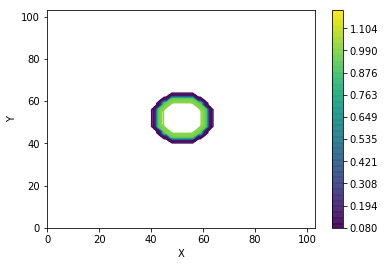

0.5
0.3147759497489771
0.3072307555594914
1


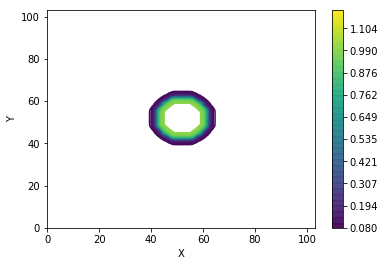

0.303805794233281
0.30201838176367135
0.2995052455458392
2


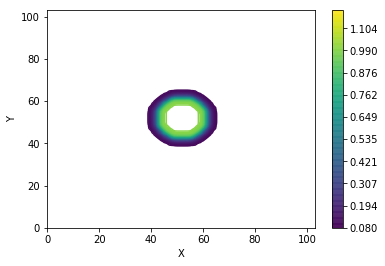

0.2944157249141268
0.28955570457330426
0.2865992619337122
0.28481176467780334
3


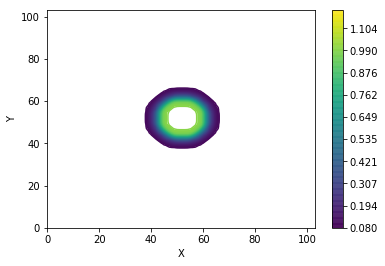

0.28208335044774596
0.2804621084790567
0.27939244034510524
4


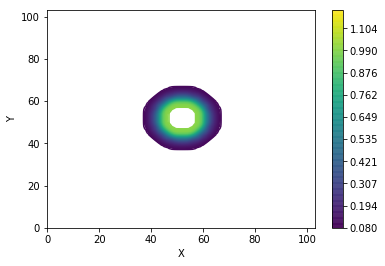

0.27623009748120675
0.2740892259822543
0.2730524580739107
0.2726325880290446
5


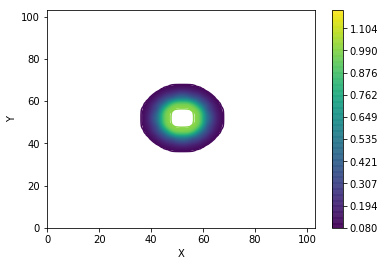

0.2728573856565585
0.27318322092452096
0.27040941457336315
0.26848320395258957
6


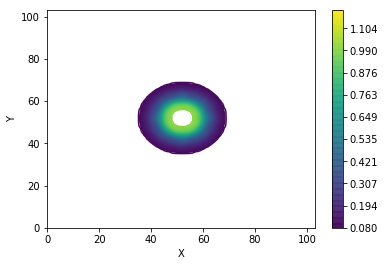

0.2674857848735191
0.26720069494430093
0.2674696636331241
7


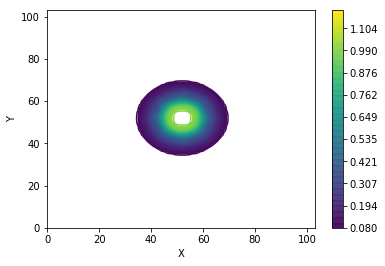

0.26727434131355243
0.26544440744817854
0.26445523485321265
0.26412803884619246
8


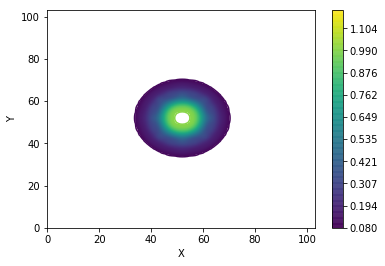

0.2643310291316096
0.2649620266519667
0.26559200177297093
0.2645166454894452
9


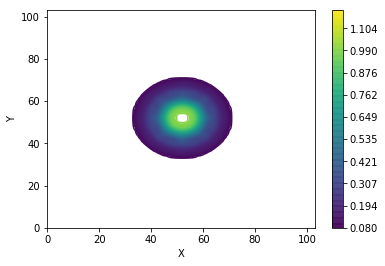

0.26411402897655595
0.2642197626738579
0.2647113090690327
0.26537925064481915
finished


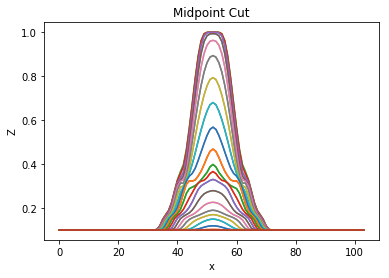

In [12]:
main()

#As can be seen below, the midpoint plot is very smooth with very little noise about the curve, it smoothly increases matching the time that it takes to increase the energy toward the center


In [9]:
#Here i will implement the code using 1st order LR boundaries to compare
# 2-D Godunov scheme using midpoint of cell to make calculation (second order accurate) with midpoint cuts to plot progression. 

import numpy as np
import matplotlib.pylab as p
from mpl_toolkits.mplot3d import Axes3D 

L=100.; Nx=100; NGHOST=2; Ny=100
tend=10.1; Dtout=1.

Nxg=Nx+2*NGHOST  # Total grid number including ghost zones
Nyg=Ny+2*NGHOST

ist=2           # i direction: active zone starting grid number
ien=Nx+2        # i direction: active zone ending grid number
jst=2           # j direction: active zone starting grid number
jen=Ny+2

NHYDRO=5 # 5 varialbes, rho, mx1, mx2, mx3, E, or rho, vx1, vx2, vx3, pressure
gamma=1.4

dx=L/Nx
dy=L/Ny
dareax=dy       # area perpendicular to the x direction
dareay=dx       # area perpendicular to the y direction
dvol=dy*dx      # volume of each grid

Wsave=np.zeros((Nyg,Nxg,int(tend/Dtout)+1,NHYDRO), float)

def main():

    U=np.zeros((Nyg,Nxg,NHYDRO), float)  # conserved variable
    W=np.zeros((Nyg,Nxg,NHYDRO), float)  # primative variable
    Um=np.zeros((Nyg,Nxg,NHYDRO), float)  # conserved variable at mid point
    Wm=np.zeros((Nyg,Nxg,NHYDRO), float)  # primative variable at mid point
    Fluxx=np.zeros((Nyg,Nxg,NHYDRO), float)  # flux from the x-direction interface
    Fluxy=np.zeros((Nyg,Nxg,NHYDRO), float)  # flux from the y-direction interface
    fluxa=np.zeros(NHYDRO,float)             # temperal flux for the single interface
    wl=np.zeros(NHYDRO, float)          # left state
    wr=np.zeros(NHYDRO, float)          # right state

    # setup the problem
    prob2(U,W)
    Um[:]=U[:]
    Wm[:]=W[:]

    toutn=0
    t=0.
    while t < tend:   
        # time step
        dt=0.4*np.min(np.min([dx,dy])/(np.sqrt(W[jst:jen,ist:ien,1]*W[jst:jen,ist:ien,1]+W[jst:jen,ist:ien,2]*W[jst:jen,ist:ien,2]+W[jst:jen,ist:ien,3]*W[jst:jen,ist:ien,3])+np.sqrt(gamma*W[jst:jen,ist:ien,4]/W[jst:jen,ist:ien,0])))
        # calculate x interface flux
        for j in np.arange(jst, jen+1):
            for i in np.arange(ist, ien+1):                       
                reconst(W, wl, wr, i, j, dx, dy, 1)    
                rsolver(wl,wr,fluxa,1)
                Fluxx[j,i,:]=fluxa[:]
        # calculate y interface flux
        for i in np.arange(ist, ien+1):
            for j in np.arange(jst, jen+1):
                reconst(W, wl, wr, i, j, dx, dy, 2)
                rsolver(wl,wr,fluxa,2)
                Fluxy[j,i,:]=fluxa[:]
        # update all the active zone
        for j in np.arange(jst,jen):
            for i in np.arange(ist, ien): 
                for idex in range(NHYDRO):
                    U[j,i,idex]=U[j,i,idex] + (Fluxx[j,i,idex] - Fluxx[j,i+1,idex])*dareax*dt/dvol + (Fluxy[j,i,idex] - Fluxy[j+1,i,idex])*dareay*dt/dvol
        contoprim(U, W)
        boundary(W)                       
                
                
        if t >= toutn*Dtout: 
            print(toutn)   
            x = list(range(0, Nxg))                       # Plot alternate pts
            y = list(range(0, Nyg))                      
            X, Y = p.meshgrid(x, y)                       
            Z = W[Y,X,0]                                  # plot 0: density,...
            levels=p.arange(np.min(Z)*0.8,np.max(Z)*1.2,(np.max(Z)*1.2 - np.min(Z)*0.8)/256.)
            CS=p.contour(x,y,Z,levels)
            p.xlabel('X')
            p.ylabel('Y')
            p.colorbar(CS)
            p.show()  
            toutn += 1    
            
            
        t+=dt
        print(dt)
    
        

                                 
    print("finished")
    p.title('LR Cut')
    p.xlabel('x')
    p.ylabel('Z')
    p.plot(x,Z)
    p.show()

    

# Sod shock tube in the x direction    
def prob1(U,W):
    for j in range(Nyg):
        for i in range(int(Nxg/2)):
            U[j,i,0]=8.
            W[j,i,0]=8.
            W[j,i,4]=10./gamma
            U[j,i,4]=W[j,i,4]/(gamma-1) 
        for i in range(int(Nxg/2), Nxg):
            U[j,i,0]=1.
            W[j,i,0]=1.
            W[j,i,4]=1.0/gamma
            U[j,i,4]=W[j,i,4]/(gamma-1) 
    boundary(W)

# blast wave solution  
def prob2(U,W):
    for j in range(Nyg):
        for i in range(Nxg):
            if (i-Nxg/2.)*(i-Nxg/2)+(j-Nyg/2.)*(j-Nyg/2)<100.0:
                U[j,i,0]=1.
                W[j,i,0]=1.
                W[j,i,4]=1.0/gamma
                U[j,i,4]=W[j,i,4]/(gamma-1) 
            else:
                U[j,i,0]=0.1
                W[j,i,0]=0.1
                W[j,i,4]=0.1/gamma
                U[j,i,4]=W[j,i,4]/(gamma-1) 
    boundary(W)


    
# reconstruction
def reconst(W, wl, wr, i, j, dlx, dly, dire):
    reconst_plm(W, wl, wr, i, j, dlx, dly, dire)
    
# donor cell reconstruction
def reconst_donor(W, wl, wr, i, j, dlx, dly, dire):
    if dire==1:
        for idex in range(NHYDRO):
            wl[idex]=W[j,i-1,idex]
            wr[idex]=W[j,i,idex]
    if dire==2:
        for idex in range(NHYDRO):
            wl[idex]=W[j-1,i,idex]
            wr[idex]=W[j,i,idex]
            
        
# piecewise linear reconstruction
def reconst_plm(W, wl, wr, i, j, dlx, dly, dire):
    for idex in range(NHYDRO):
        if dire==1:
            wm1=W[j,i-1,idex]
            wm2=W[j,i-2,idex]
            w=W[j,i,idex]
            wp1=W[j,i+1,idex]
            dl=dlx
        if dire==2:
            wm1=W[j-1,i,idex]
            wm2=W[j-2,i,idex]
            w=W[j,i,idex]
            wp1=W[j+1,i,idex]
            dl=dly
        dql=(wm1-wm2)/dl
        dqc=(w-wm1)/dl
        dqr=(wp1-w)/dl
        
        dq2=dql*dqc
        if (dq2>0.0):
            dqm=dq2/(dql+dqc)
        else:
            dqm=0.0
            
        wl[idex]=wm1+dqm*dl

        dq2=dqc*dqr
        if(dq2>0.0):
            dqm=dq2/(dqc+dqr)
        else:
            dqm=0.0
        
        wr[idex]=w-dqm*dl

# hlle Reimann solver
def rsolver(wl,wr,fluxa,dire):
    # Compute Roe-averaged state
    if dire==1:
        ivx=1
        ivy=2
    if dire==2:
        ivx=2
        ivy=1
    sqrtdl = np.sqrt(wl[0])   
    sqrtdr = np.sqrt(wr[0])
    isdlpdr = 1./(sqrtdl+sqrtdr)
    
    roed=sqrtdl*sqrtdr
    roevx=(sqrtdl*wl[ivx]+sqrtdr*wr[ivx])*isdlpdr
    roevy=(sqrtdl*wl[ivy]+sqrtdr*wr[ivy])*isdlpdr
    roevz=(sqrtdl*wl[3]+sqrtdr*wr[3])*isdlpdr
        #The enthalpy H=(E+P)/d is averaged sqrtdl*hl = sqrtdl*(el+pl)/dl = (el+pl)/sqrtdl
    el = wl[4]/(gamma-1.)+0.5*wl[0]*(wl[ivx]*wl[ivx]+wl[ivy]*wl[ivy]+wl[3]*wl[3])
    er = wr[4]/(gamma-1.)+0.5*wr[0]*(wr[ivx]*wr[ivx]+wr[ivy]*wr[ivy]+wr[3]*wr[3])
    roeh = ((el+wl[4])/sqrtdl+(er+wr[4])/sqrtdr)*isdlpdr
    
    # Compute sound speed in L,R, and Roe-averaged state
    cl=np.sqrt(gamma*wl[4]/wl[0])
    cr=np.sqrt(gamma*wr[4]/wr[0])
    q=roeh-0.5*(roevx*roevx+roevy*roevy+roevz*roevz)
    if(q<0.0):
        q=0.0
    a=np.sqrt((gamma-1.)*q)

    # Compute the max/min wave speeds based on L/R and Roe-averaged values
    al=min([roevx-a,wl[ivx]-cl])
    ar=max([roevx+a,wr[ivx]+cr])
    if ar>0.0:
        bp=ar
    else:
        bp=0.0
    if al<0.0:
        bm=al
    else:
        bm=0.0
        
    #Compute L/R fluxes along the lines bm/bp: F_L - (S_L)U_L; F_R - (S_R)U_R
    fl=np.zeros(NHYDRO, float)
    fr=np.zeros(NHYDRO, float)
    
    fl[0]=wl[0]*wl[ivx]-bm*wl[0]
    fr[0]=wr[0]*wr[ivx]-bp*wr[0]
    fl[ivx]=wl[0]*wl[ivx]*(wl[ivx]-bm)
    fr[ivx]=wr[0]*wr[ivx]*(wr[ivx]-bp)
    fl[ivy]=wl[0]*wl[ivy]*(wl[ivx]-bm)
    fr[ivy]=wr[0]*wr[ivy]*(wr[ivx]-bp)
    fl[3]=wl[0]*wl[3]*(wl[ivx]-bm)
    fr[3]=wr[0]*wr[3]*(wr[ivx]-bp)
    fl[ivx] += wl[4]
    fr[ivx] += wr[4]
    fl[4] = el*(wl[ivx]-bm)+wl[4]*wl[ivx]
    fr[4] = er*(wr[ivx]-bp)+wr[4]*wr[ivx]
    
    if (bp==bm):
        tmp = 0.0
    else:
        tmp = 0.5*(bp+bm)/(bp-bm)
        
    fluxa[0]=0.5*(fl[0]+fr[0])+(fl[0]-fr[0])*tmp
    fluxa[ivx]=0.5*(fl[ivx]+fr[ivx])+(fl[ivx]-fr[ivx])*tmp
    fluxa[ivy]=0.5*(fl[ivy]+fr[ivy])+(fl[ivy]-fr[ivy])*tmp
    fluxa[3]=0.5*(fl[3]+fr[3])+(fl[3]-fr[3])*tmp
    fluxa[4]=0.5*(fl[4]+fr[4])+(fl[4]-fr[4])*tmp
    
# conservative variables to primitive variables
def contoprim(U, W):
    for j in np.arange(jst,jen):
            for i in np.arange(ist, ien):
                W[j,i,0]=max([U[j,i,0],1.e-30]) # to add stability for the Reimann solver, make sure density and pressure are positive
                W[j,i,1]=U[j,i,1]/W[j,i,0]
                W[j,i,2]=U[j,i,2]/W[j,i,0]
                W[j,i,3]=U[j,i,3]/W[j,i,0]
                W[j,i,4]=max([(U[j,i,4]-0.5*W[j,i,0]*(W[j,i,1]**2+W[j,i,2]**2+W[j,i,3]**2))*(gamma-1),1.e-30])
    
# primitive variables to conservative variables   
def primtocon(W,U):
    for j in np.arange(jst,jen):
            for i in np.arange(ist, ien):
                U[j,i,0]=W[j,i,0]
                U[j,i,1]=W[j,i,1]*W[j,i,0]
                U[j,i,2]=W[j,i,2]*W[j,i,0]
                U[j,i,3]=W[j,i,3]*W[j,i,0]
                U[j,i,4]=0.5*W[j,i,0]*(W[j,i,1]**2+W[j,i,2]**2+W[j,i,3]**2)+W[j,i,4]/(gamma-1)

# boundary condition
def boundary(W):    
    periodic(W)
    
# periodic boundary
def periodic(W):
    for j in np.arange(jst,jen):
        for idex in range(NHYDRO):
            W[j,0,idex]=W[j,Nxg-4,idex]
            W[j,1,idex]=W[j,Nxg-3,idex]
            W[j,Nxg-2,idex]=W[j,2,idex]
            W[j,Nxg-1,idex]=W[j,3,idex]
                
    for i in np.arange(0,Nxg):
        for idex in range(NHYDRO):
            W[0,i,idex]=W[Nyg-4,i,idex]
            W[1,i,idex]=W[Nyg-3,i,idex]
            W[Nyg-2,i,idex]=W[2,i,idex]
            W[Nyg-1,i,idex]=W[3,i,idex]
    
# outflow boundary
def outflow(W):
    for j in np.arange(jst,jen):
        for idex in range(NHYDRO):
            W[j,0,idex]=W[j,2,idex]
            W[j,1,idex]=W[j,2,idex]
            W[j,Nxg-2,idex]=W[j,Nxg-3,idex]
            W[j,Nxg-1,idex]=W[j,Nxg-3,idex]
                
    for i in np.arange(0,Nxg):
        for idex in range(NHYDRO):
            W[0,i,idex]=W[2,i,idex]
            W[1,i,idex]=W[2,i,idex]
            W[Nyg-2,i,idex]=W[Nyg-3,i,idex]
            W[Nyg-1,i,idex]=W[Nyg-3,i,idex]

0


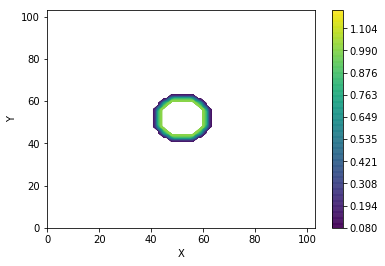

0.4
0.27987378309230626
0.2504821157991125
0.23860211141851415
1


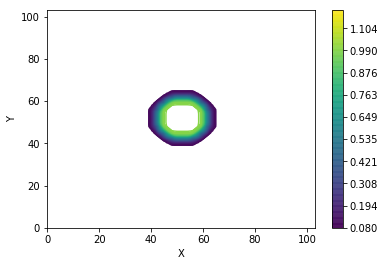

0.22832722988969906
0.22157711100374666
0.2148625251891385
0.21134946227893048
2


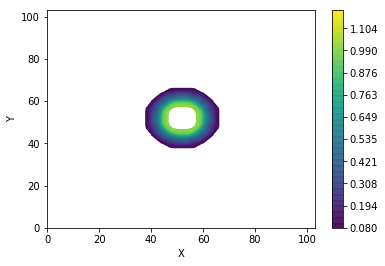

0.20479346050408168
0.20251011801837873
0.2034144538598807
0.20122411502229354
0.20227356911149458
3


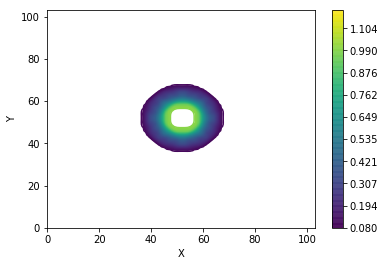

0.1978215660158429
0.19905883715980666
0.19673270912558594
0.19306858305790647
0.19441609969521215
4


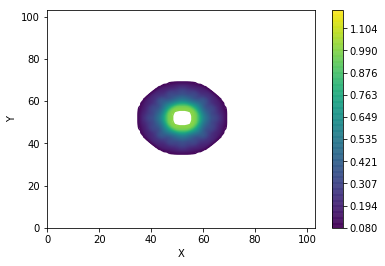

0.19487246478736375
0.1910406059770516
0.19213487006340324
0.19453166227188048
0.19133344290132046
5


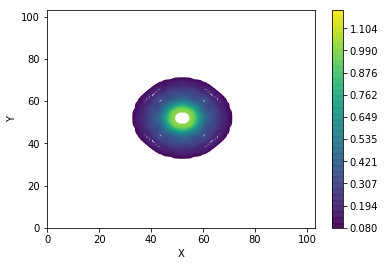

0.1923954939765546
0.1941561644797454
0.19416059483925366
0.1945421348519255
0.1961453168512518
0.19899792071720157
6


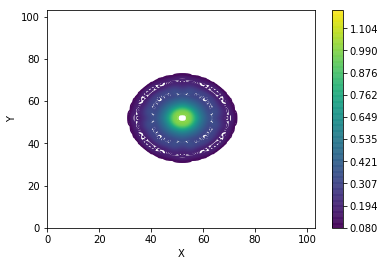

0.1989171255077384
0.20038060314520156
0.20249762687513267
0.20412678879085872
0.20591801899578366
7


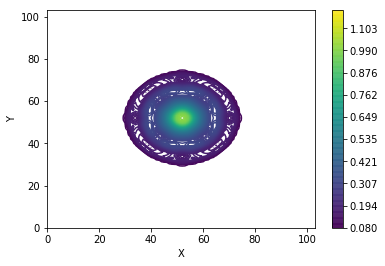

0.2064867463266681
0.20725092857851413
0.20820544916596306
0.20997791552085793
8


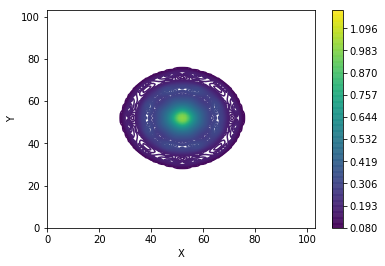

0.2106226442920851
0.21162935870969535
0.21298862202363877
0.2141072457858403
0.21495432612051554
9


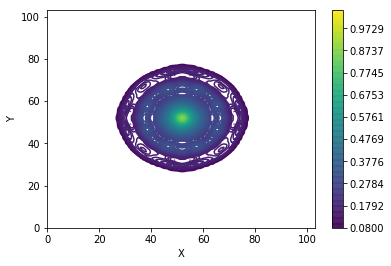

0.21617943289887856
0.2177340224075035
0.217998504397226
0.21762040992019036
0.21788991085272336
finished


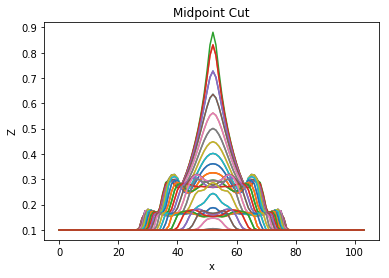

In [10]:
main()

A glance at the cut comparisons will show that the midpoint version has many less oscillations about the values of the shock blast. This oscillation makes takingi any given value highly innacurate compared to the midpoint method.